In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# name of the notebook
name_notebook = "sweep_12c_e_v2"

In [4]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="To compare with sweep_12h_e_Am_Xqm (now the same number of qubits/neurons) with a classical model with the same number of parameters.",
#     repetitions=list(range(1, 3)),
#     n_layers_block=[1,2,5,12,20],
#     embedding_dim=[1,5],
# )

In [5]:
# sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-1", day='0914', initial_path=initial_path)



 --- SWEEP POINT 1/20: (1, 1, 1) ---
 --- parameters sweeping: ['repetitions', 'n_layers_block', 'embedding_dim'] 

12 4
Epoch [0/2], Loss epoch: 0.8231, Loss validation: 0.8236
	 Validation string, 	 i: 2628; 	 prediction: -0.3622, 	 target: -0.2890, 	 loss: 0.0054
	 Validation string, 	 i: 1712; 	 prediction: -0.3232, 	 target: -0.3073, 	 loss: 0.0003
	 Validation string, 	 i: 803; 	 prediction: -0.4262, 	 target: -0.4325, 	 loss: 0.0000
Epoch [1/2], Loss epoch: 0.0087, Loss validation: 0.0080, Time remaining: ~0.0h 0.0m 18s
	 Validation string, 	 i: 1855; 	 prediction: -0.4181, 	 target: -0.4453, 	 loss: 0.0007
	 Validation string, 	 i: 4115; 	 prediction: -0.1411, 	 target: -0.2249, 	 loss: 0.0070
	 Validation string, 	 i: 2041; 	 prediction: -0.2685, 	 target: -0.3041, 	 loss: 0.0013
Epoch [2/2], Loss epoch: 0.0079, Loss validation: 0.0082, Time remaining: ~0.0h 0.0m 0s


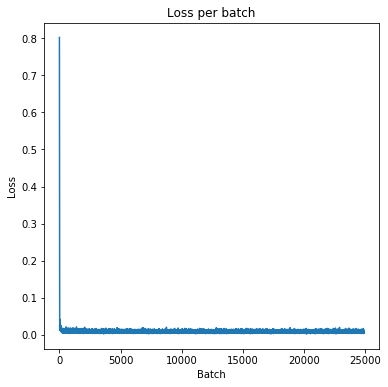

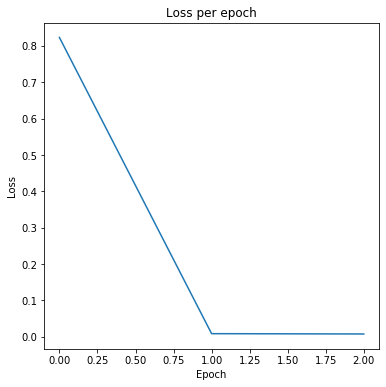

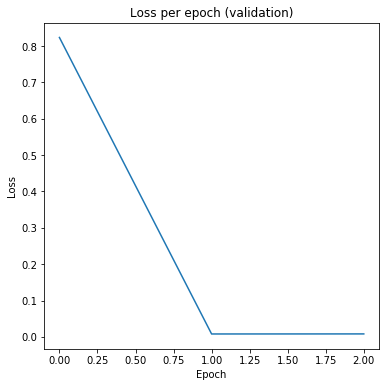

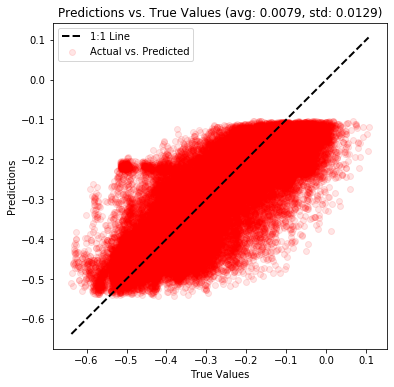

Mean loss: 0.007940161024239872, std loss: 0.012889835744674324


 --- SWEEP POINT 2/20: (1, 1, 5) ---
 --- time reamining: 04:20:17.73 

60 6
Epoch [0/2], Loss epoch: 0.0355, Loss validation: 0.0355
	 Validation string, 	 i: 394; 	 prediction: -0.4817, 	 target: -0.5208, 	 loss: 0.0015
	 Validation string, 	 i: 1580; 	 prediction: -0.2214, 	 target: -0.2127, 	 loss: 0.0001
	 Validation string, 	 i: 3984; 	 prediction: -0.1260, 	 target: -0.0484, 	 loss: 0.0060
Epoch [1/2], Loss epoch: 0.0066, Loss validation: 0.0067, Time remaining: ~0.0h 0.0m 18s
	 Validation string, 	 i: 4341; 	 prediction: -0.1568, 	 target: -0.2916, 	 loss: 0.0182
	 Validation string, 	 i: 3739; 	 prediction: -0.1119, 	 target: -0.1388, 	 loss: 0.0007
	 Validation string, 	 i: 3854; 	 prediction: -0.4007, 	 target: -0.3204, 	 loss: 0.0064
Epoch [2/2], Loss epoch: 0.0060, Loss validation: 0.0061, Time remaining: ~0.0h 0.0m 0s


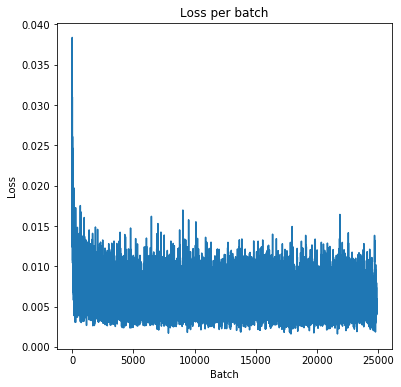

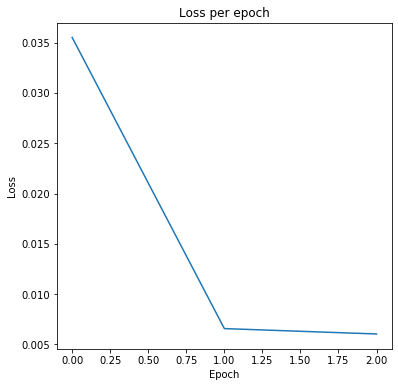

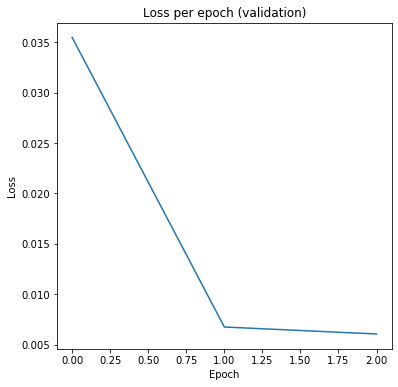

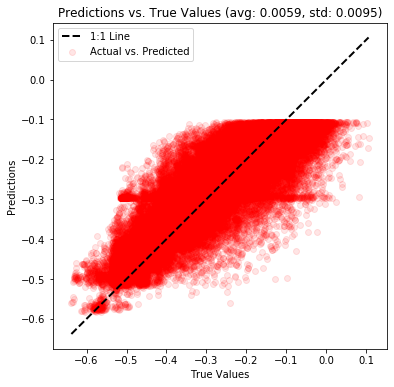

Mean loss: 0.005850428710805288, std loss: 0.009474683340320247


 --- SWEEP POINT 3/20: (1, 2, 1) ---
 --- time reamining: 02:10:54.51 

12 4
Epoch [0/2], Loss epoch: 0.2497, Loss validation: 0.2501
	 Validation string, 	 i: 1104; 	 prediction: -0.1992, 	 target: -0.1022, 	 loss: 0.0094
	 Validation string, 	 i: 2195; 	 prediction: -0.1163, 	 target: -0.2222, 	 loss: 0.0112
	 Validation string, 	 i: 3393; 	 prediction: -0.1328, 	 target: -0.1716, 	 loss: 0.0015
Epoch [1/2], Loss epoch: 0.0084, Loss validation: 0.0082, Time remaining: ~0.0h 0.0m 16s
	 Validation string, 	 i: 263; 	 prediction: -0.1628, 	 target: -0.2448, 	 loss: 0.0067
	 Validation string, 	 i: 1419; 	 prediction: -0.3628, 	 target: -0.4398, 	 loss: 0.0059
	 Validation string, 	 i: 999; 	 prediction: -0.3927, 	 target: -0.1509, 	 loss: 0.0585
Epoch [2/2], Loss epoch: 0.0078, Loss validation: 0.0080, Time remaining: ~0.0h 0.0m 0s


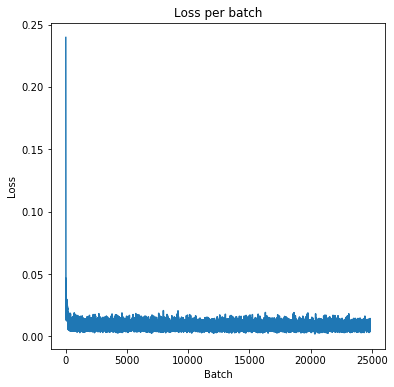

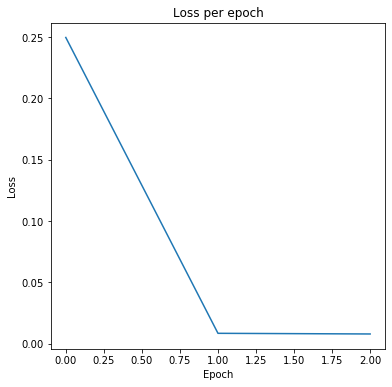

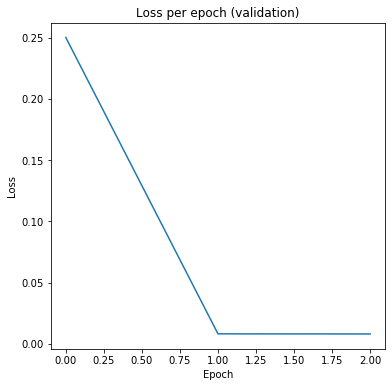

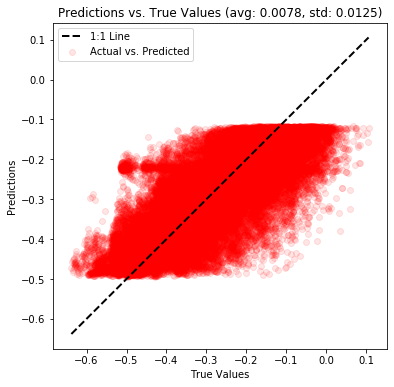

Mean loss: 0.007754519083210688, std loss: 0.0125193357367882


 --- SWEEP POINT 4/20: (1, 2, 5) ---
 --- time reamining: 01:26:18.86 

60 6
Epoch [0/2], Loss epoch: 0.0890, Loss validation: 0.0893
	 Validation string, 	 i: 1154; 	 prediction: -0.4712, 	 target: -0.4636, 	 loss: 0.0001
	 Validation string, 	 i: 3432; 	 prediction: -0.4860, 	 target: -0.5069, 	 loss: 0.0004
	 Validation string, 	 i: 1315; 	 prediction: -0.3258, 	 target: -0.2373, 	 loss: 0.0078
Epoch [1/2], Loss epoch: 0.0068, Loss validation: 0.0061, Time remaining: ~0.0h 0.0m 17s
	 Validation string, 	 i: 1197; 	 prediction: -0.3199, 	 target: -0.2784, 	 loss: 0.0017
	 Validation string, 	 i: 873; 	 prediction: -0.2137, 	 target: -0.2132, 	 loss: 0.0000
	 Validation string, 	 i: 1088; 	 prediction: -0.4836, 	 target: -0.5099, 	 loss: 0.0007
Epoch [2/2], Loss epoch: 0.0062, Loss validation: 0.0060, Time remaining: ~0.0h 0.0m 0s


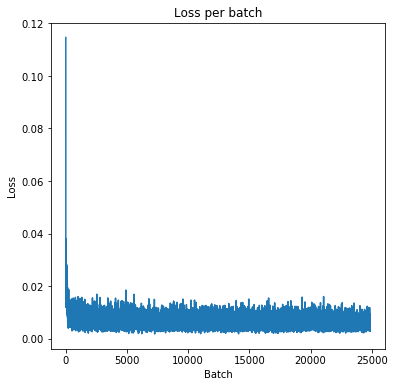

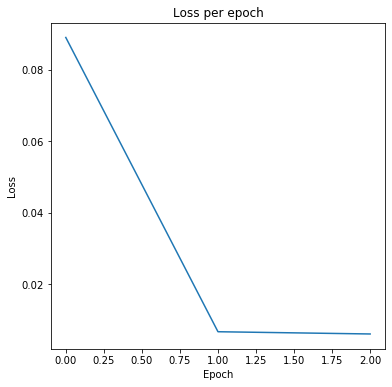

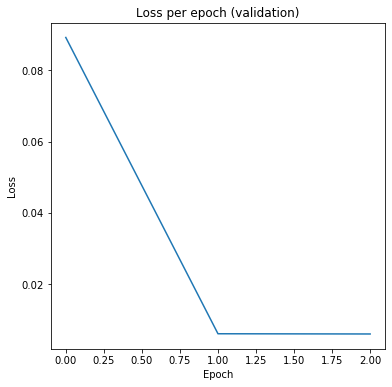

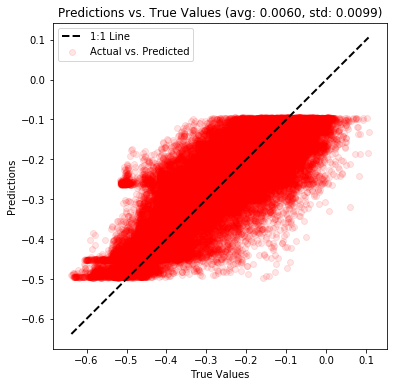

Mean loss: 0.005989980515527062, std loss: 0.009928722648746346


 --- SWEEP POINT 5/20: (1, 5, 1) ---
 --- time reamining: 01:03:49.71 

12 4
Epoch [0/2], Loss epoch: 0.0870, Loss validation: 0.0872
	 Validation string, 	 i: 2632; 	 prediction: -0.1540, 	 target: -0.2156, 	 loss: 0.0038
	 Validation string, 	 i: 2339; 	 prediction: -0.2492, 	 target: -0.1800, 	 loss: 0.0048
	 Validation string, 	 i: 578; 	 prediction: -0.4247, 	 target: -0.4153, 	 loss: 0.0001
Epoch [1/2], Loss epoch: 0.0109, Loss validation: 0.0085, Time remaining: ~0.0h 0.0m 18s
	 Validation string, 	 i: 1938; 	 prediction: -0.3038, 	 target: -0.3061, 	 loss: 0.0000
	 Validation string, 	 i: 2382; 	 prediction: -0.2014, 	 target: -0.1365, 	 loss: 0.0042
	 Validation string, 	 i: 3949; 	 prediction: -0.1462, 	 target: -0.0767, 	 loss: 0.0048
Epoch [2/2], Loss epoch: 0.0080, Loss validation: 0.0077, Time remaining: ~0.0h 0.0m 0s


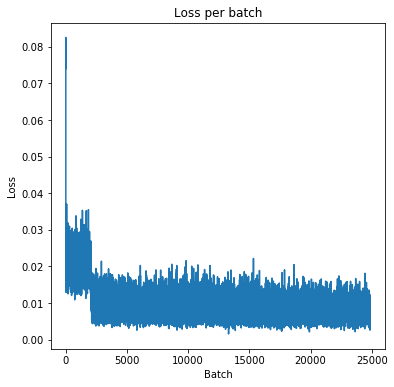

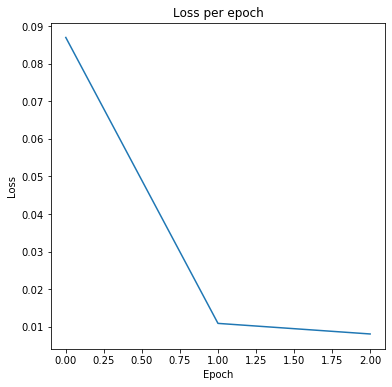

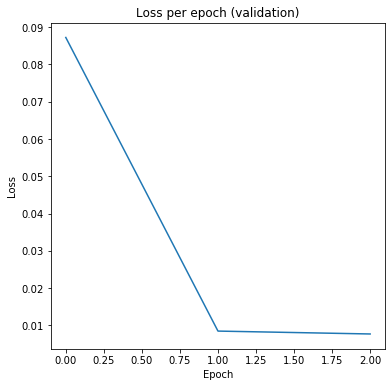

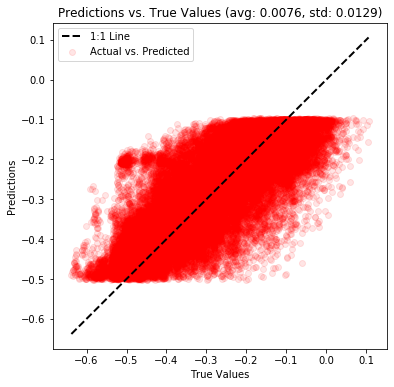

Mean loss: 0.007638847904799406, std loss: 0.012871322550145264


 --- SWEEP POINT 6/20: (1, 5, 5) ---
 --- time reamining: 00:50:40.91 

60 6
Epoch [0/2], Loss epoch: 1.3558, Loss validation: 1.3568
	 Validation string, 	 i: 1379; 	 prediction: -0.1840, 	 target: -0.2589, 	 loss: 0.0056
	 Validation string, 	 i: 364; 	 prediction: -0.1448, 	 target: -0.1628, 	 loss: 0.0003
	 Validation string, 	 i: 4287; 	 prediction: -0.4607, 	 target: -0.4888, 	 loss: 0.0008
Epoch [1/2], Loss epoch: 0.0100, Loss validation: 0.0072, Time remaining: ~0.0h 0.0m 22s
	 Validation string, 	 i: 1588; 	 prediction: -0.1199, 	 target: -0.0377, 	 loss: 0.0067
	 Validation string, 	 i: 2067; 	 prediction: -0.1203, 	 target: -0.2356, 	 loss: 0.0133
	 Validation string, 	 i: 3083; 	 prediction: -0.4337, 	 target: -0.3721, 	 loss: 0.0038
Epoch [2/2], Loss epoch: 0.0068, Loss validation: 0.0065, Time remaining: ~0.0h 0.0m 0s


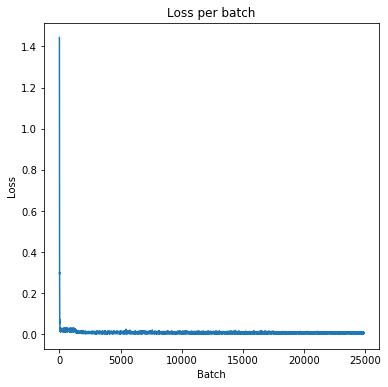

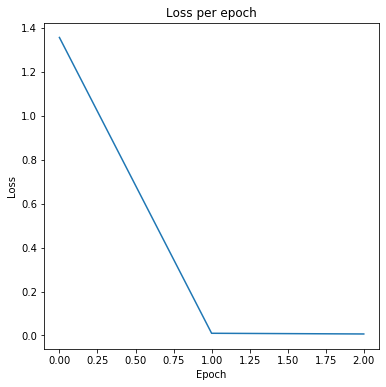

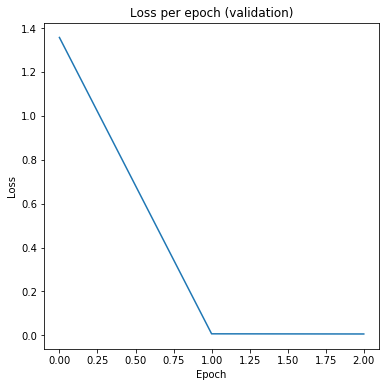

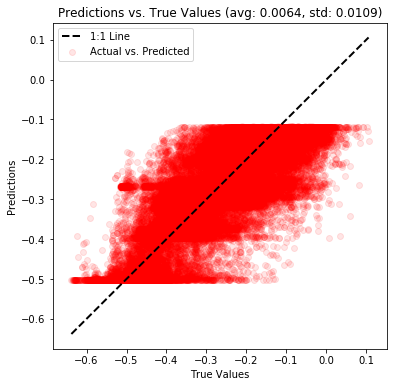

Mean loss: 0.006433905296397853, std loss: 0.010938439355739293


 --- SWEEP POINT 7/20: (1, 12, 1) ---
 --- time reamining: 00:41:52.40 

12 4
Epoch [0/2], Loss epoch: 0.1076, Loss validation: 0.1079
	 Validation string, 	 i: 3051; 	 prediction: -0.2352, 	 target: -0.2498, 	 loss: 0.0002
	 Validation string, 	 i: 4202; 	 prediction: -0.3469, 	 target: -0.0863, 	 loss: 0.0679
	 Validation string, 	 i: 2071; 	 prediction: -0.3501, 	 target: -0.2524, 	 loss: 0.0095
Epoch [1/2], Loss epoch: 0.0177, Loss validation: 0.0096, Time remaining: ~0.0h 0.0m 27s
	 Validation string, 	 i: 3634; 	 prediction: -0.1488, 	 target: -0.1190, 	 loss: 0.0009
	 Validation string, 	 i: 1678; 	 prediction: -0.1456, 	 target: -0.0443, 	 loss: 0.0103
	 Validation string, 	 i: 1747; 	 prediction: -0.3948, 	 target: -0.4532, 	 loss: 0.0034
Epoch [2/2], Loss epoch: 0.0088, Loss validation: 0.0080, Time remaining: ~0.0h 0.0m 0s


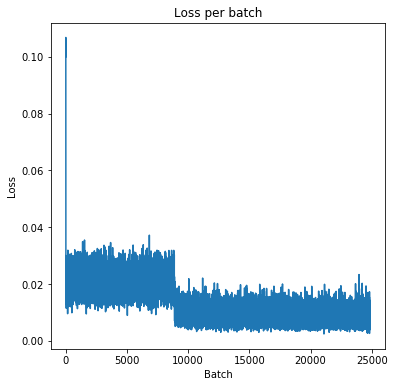

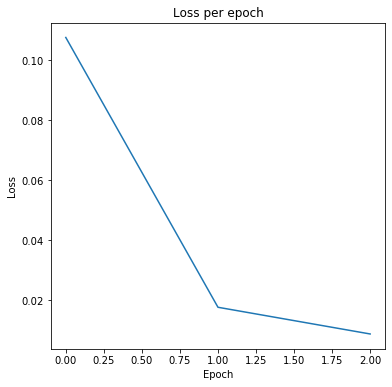

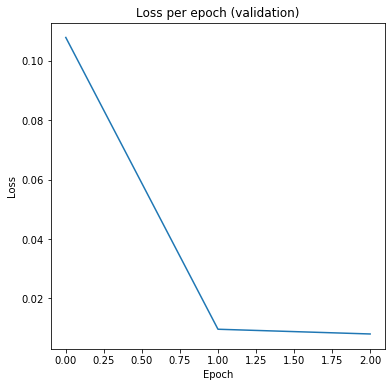

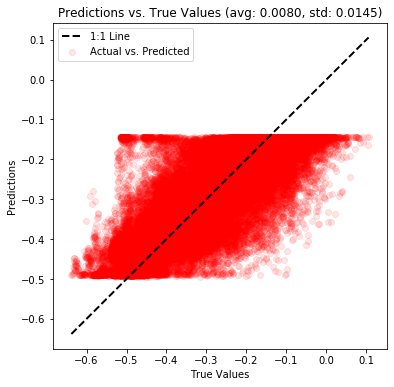

Mean loss: 0.007953415074459472, std loss: 0.014494260837178174


 --- SWEEP POINT 8/20: (1, 12, 5) ---
 --- time reamining: 00:35:45.18 

60 6
Epoch [0/2], Loss epoch: 0.1939, Loss validation: 0.1943
	 Validation string, 	 i: 37; 	 prediction: -0.2245, 	 target: -0.2848, 	 loss: 0.0036
	 Validation string, 	 i: 83; 	 prediction: -0.2327, 	 target: -0.1389, 	 loss: 0.0088
	 Validation string, 	 i: 3831; 	 prediction: -0.1413, 	 target: -0.1600, 	 loss: 0.0004
Epoch [1/2], Loss epoch: 0.0149, Loss validation: 0.0071, Time remaining: ~0.0h 0.0m 29s
	 Validation string, 	 i: 1412; 	 prediction: -0.4621, 	 target: -0.4829, 	 loss: 0.0004
	 Validation string, 	 i: 972; 	 prediction: -0.1194, 	 target: -0.1413, 	 loss: 0.0005
	 Validation string, 	 i: 859; 	 prediction: -0.4452, 	 target: -0.5646, 	 loss: 0.0143
Epoch [2/2], Loss epoch: 0.0068, Loss validation: 0.0064, Time remaining: ~0.0h 0.0m 0s


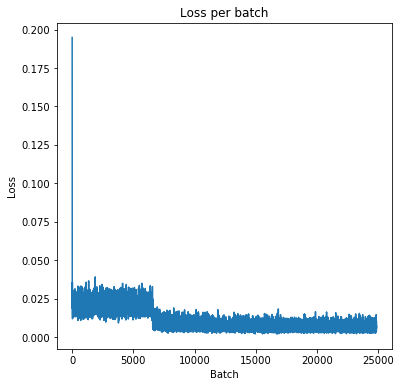

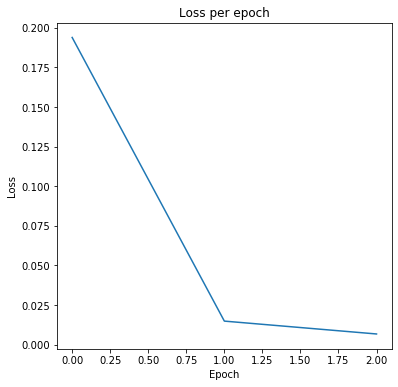

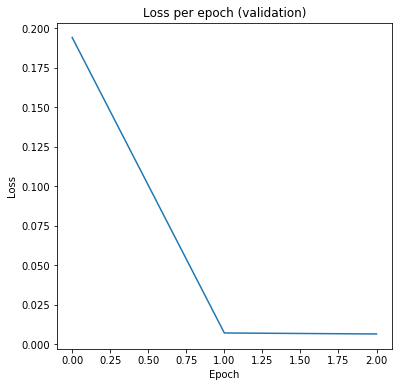

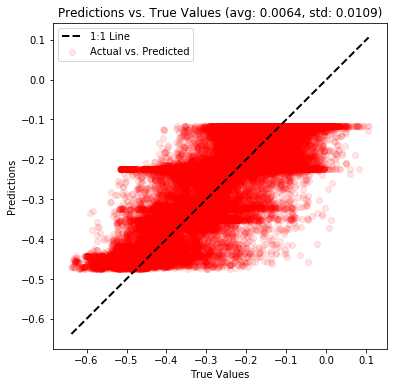

Mean loss: 0.006384224426831225, std loss: 0.010884411581123903


 --- SWEEP POINT 9/20: (1, 20, 1) ---
 --- time reamining: 00:30:56.64 

12 4
Epoch [0/2], Loss epoch: 0.2878, Loss validation: 0.2883
	 Validation string, 	 i: 4372; 	 prediction: -0.2958, 	 target: -0.3574, 	 loss: 0.0038
	 Validation string, 	 i: 1658; 	 prediction: -0.2958, 	 target: -0.0845, 	 loss: 0.0446
	 Validation string, 	 i: 2894; 	 prediction: -0.2958, 	 target: -0.1764, 	 loss: 0.0143
Epoch [1/2], Loss epoch: 0.0210, Loss validation: 0.0209, Time remaining: ~0.0h 0.0m 32s
	 Validation string, 	 i: 546; 	 prediction: -0.2742, 	 target: -0.2691, 	 loss: 0.0000
	 Validation string, 	 i: 4059; 	 prediction: -0.2742, 	 target: -0.4537, 	 loss: 0.0322
	 Validation string, 	 i: 4106; 	 prediction: -0.2742, 	 target: -0.0505, 	 loss: 0.0500
Epoch [2/2], Loss epoch: 0.0208, Loss validation: 0.0207, Time remaining: ~0.0h 0.0m 0s


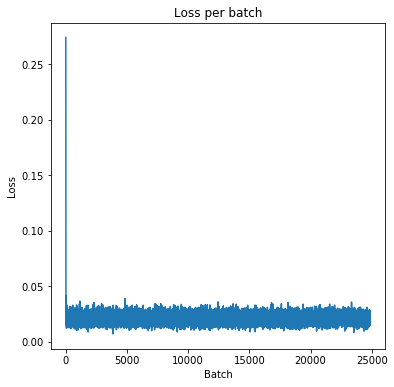

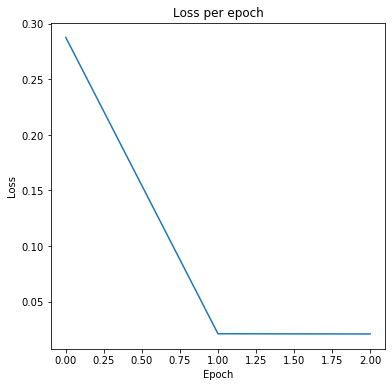

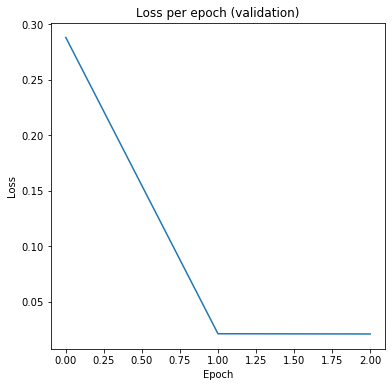

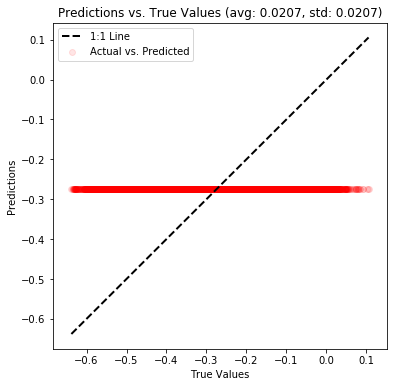

Mean loss: 0.020728429841624704, std loss: 0.020656222428306576


 --- SWEEP POINT 10/20: (1, 20, 5) ---
 --- time reamining: 00:27:06.24 

60 6
Epoch [0/2], Loss epoch: 0.2815, Loss validation: 0.2811
	 Validation string, 	 i: 1407; 	 prediction: -0.2847, 	 target: -0.4712, 	 loss: 0.0348
	 Validation string, 	 i: 2493; 	 prediction: -0.2847, 	 target: -0.2969, 	 loss: 0.0001
	 Validation string, 	 i: 1537; 	 prediction: -0.2847, 	 target: -0.2455, 	 loss: 0.0015
Epoch [1/2], Loss epoch: 0.0209, Loss validation: 0.0207, Time remaining: ~0.0h 0.0m 30s
	 Validation string, 	 i: 2223; 	 prediction: -0.2848, 	 target: -0.0422, 	 loss: 0.0588
	 Validation string, 	 i: 249; 	 prediction: -0.2848, 	 target: -0.3906, 	 loss: 0.0112
	 Validation string, 	 i: 2820; 	 prediction: -0.2848, 	 target: -0.2448, 	 loss: 0.0016
Epoch [2/2], Loss epoch: 0.0208, Loss validation: 0.0207, Time remaining: ~0.0h 0.0m 0s


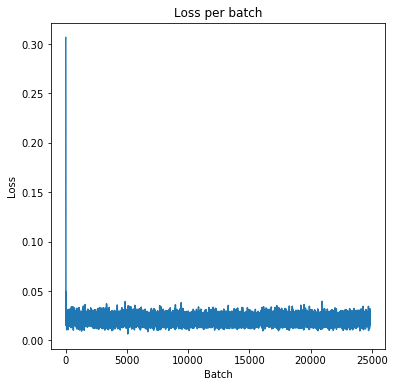

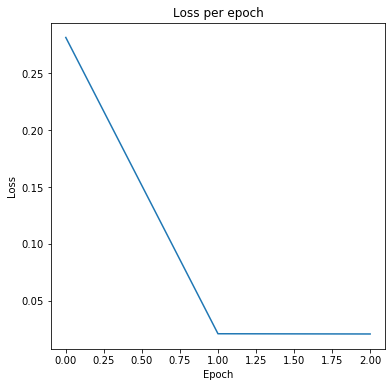

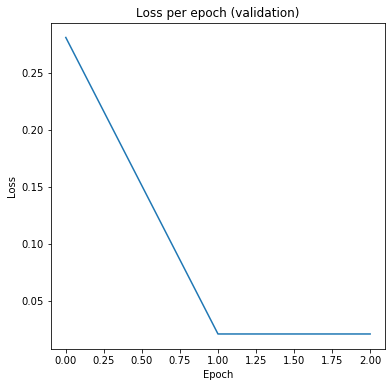

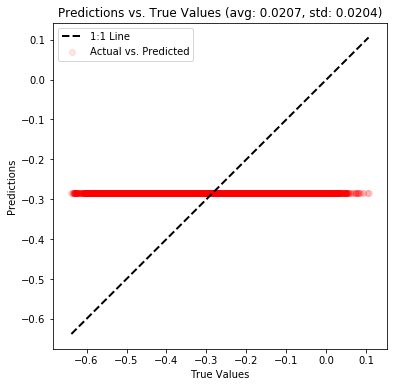

Mean loss: 0.0206918890018756, std loss: 0.020369163154889163


 --- SWEEP POINT 11/20: (2, 1, 1) ---
 --- time reamining: 00:23:40.15 

12 4
Epoch [0/2], Loss epoch: 0.0523, Loss validation: 0.0522
	 Validation string, 	 i: 4032; 	 prediction: -0.4280, 	 target: -0.2941, 	 loss: 0.0179
	 Validation string, 	 i: 1079; 	 prediction: -0.2230, 	 target: -0.1400, 	 loss: 0.0069
	 Validation string, 	 i: 295; 	 prediction: -0.2358, 	 target: -0.1503, 	 loss: 0.0073
Epoch [1/2], Loss epoch: 0.0081, Loss validation: 0.0077, Time remaining: ~0.0h 0.0m 19s
	 Validation string, 	 i: 4350; 	 prediction: -0.4047, 	 target: -0.5861, 	 loss: 0.0329
	 Validation string, 	 i: 3530; 	 prediction: -0.4360, 	 target: -0.4851, 	 loss: 0.0024
	 Validation string, 	 i: 4375; 	 prediction: -0.4110, 	 target: -0.4502, 	 loss: 0.0015
Epoch [2/2], Loss epoch: 0.0076, Loss validation: 0.0076, Time remaining: ~0.0h 0.0m 0s


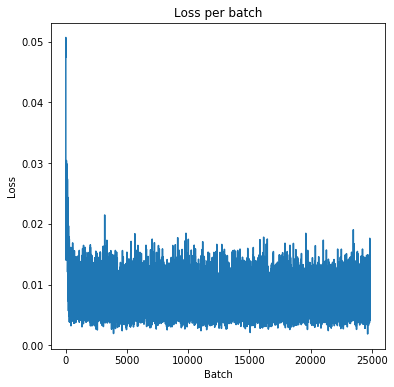

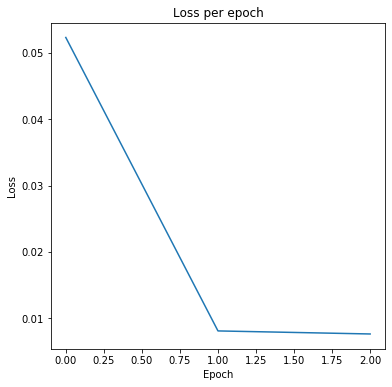

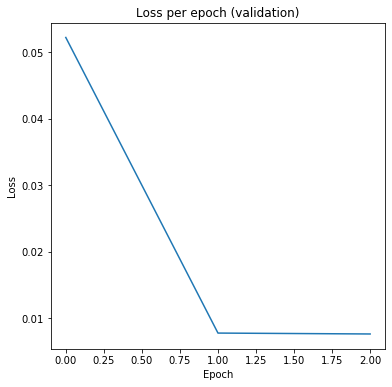

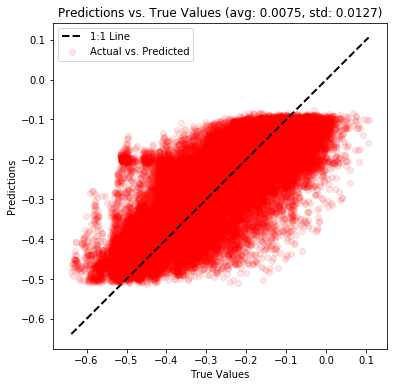

Mean loss: 0.007499717038426677, std loss: 0.0126548197486875


 --- SWEEP POINT 12/20: (2, 1, 5) ---
 --- time reamining: 00:20:06.84 

60 6
Epoch [0/2], Loss epoch: 0.1231, Loss validation: 0.1236
	 Validation string, 	 i: 2197; 	 prediction: -0.2850, 	 target: -0.2973, 	 loss: 0.0002
	 Validation string, 	 i: 4231; 	 prediction: -0.1189, 	 target: -0.0881, 	 loss: 0.0009
	 Validation string, 	 i: 468; 	 prediction: -0.1715, 	 target: -0.1526, 	 loss: 0.0004
Epoch [1/2], Loss epoch: 0.0064, Loss validation: 0.0060, Time remaining: ~0.0h 0.0m 20s
	 Validation string, 	 i: 4170; 	 prediction: -0.1235, 	 target: -0.0605, 	 loss: 0.0040
	 Validation string, 	 i: 4220; 	 prediction: -0.1864, 	 target: -0.1659, 	 loss: 0.0004
	 Validation string, 	 i: 147; 	 prediction: -0.4819, 	 target: -0.5132, 	 loss: 0.0010
Epoch [2/2], Loss epoch: 0.0057, Loss validation: 0.0058, Time remaining: ~0.0h 0.0m 0s


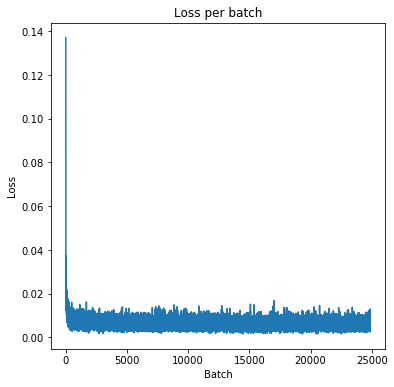

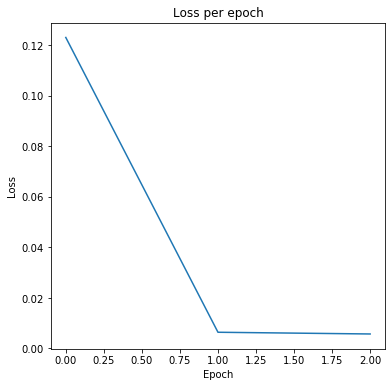

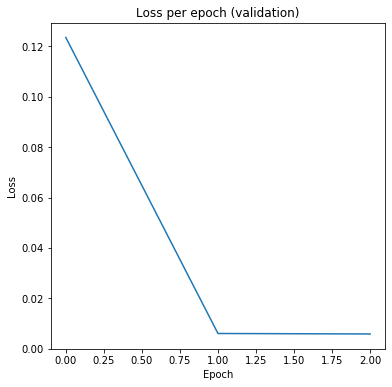

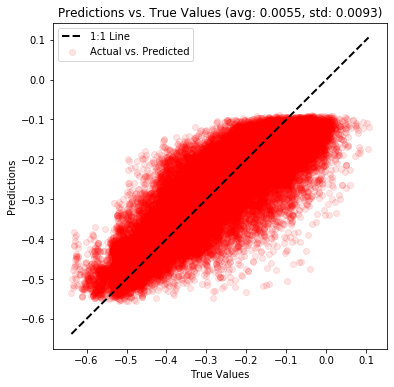

Mean loss: 0.005490267482477406, std loss: 0.009264113345641188


 --- SWEEP POINT 13/20: (2, 2, 1) ---
 --- time reamining: 00:17:00.53 

12 4
Epoch [0/2], Loss epoch: 0.2298, Loss validation: 0.2302
	 Validation string, 	 i: 2483; 	 prediction: -0.1326, 	 target: 0.0001, 	 loss: 0.0176
	 Validation string, 	 i: 1410; 	 prediction: -0.4116, 	 target: -0.4565, 	 loss: 0.0020
	 Validation string, 	 i: 3241; 	 prediction: -0.4458, 	 target: -0.4670, 	 loss: 0.0004
Epoch [1/2], Loss epoch: 0.0083, Loss validation: 0.0078, Time remaining: ~0.0h 0.0m 20s
	 Validation string, 	 i: 1165; 	 prediction: -0.4039, 	 target: -0.4865, 	 loss: 0.0068
	 Validation string, 	 i: 2081; 	 prediction: -0.2751, 	 target: -0.3932, 	 loss: 0.0139
	 Validation string, 	 i: 1991; 	 prediction: -0.1409, 	 target: -0.1885, 	 loss: 0.0023
Epoch [2/2], Loss epoch: 0.0077, Loss validation: 0.0078, Time remaining: ~0.0h 0.0m 0s


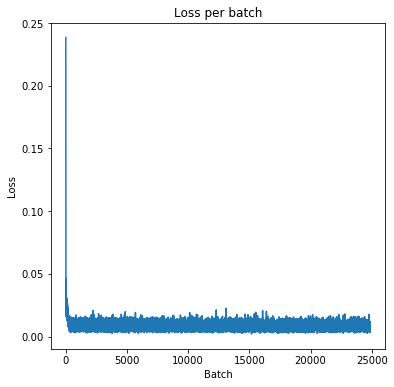

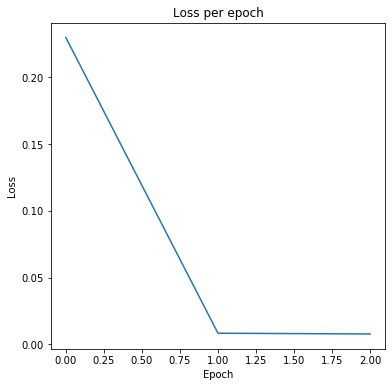

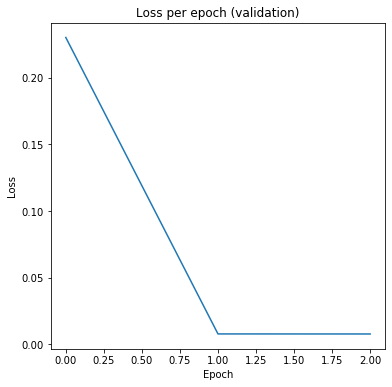

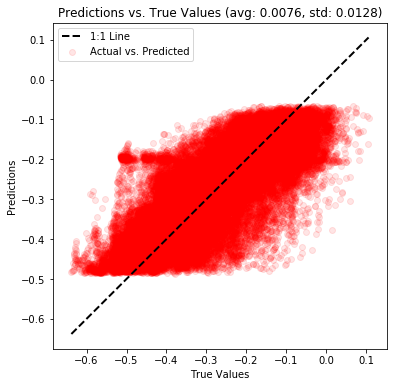

Mean loss: 0.007599893078536887, std loss: 0.012751987992345606


 --- SWEEP POINT 14/20: (2, 2, 5) ---
 --- time reamining: 00:14:14.60 

60 6
Epoch [0/2], Loss epoch: 0.5255, Loss validation: 0.5261
	 Validation string, 	 i: 3453; 	 prediction: -0.4351, 	 target: -0.4949, 	 loss: 0.0036
	 Validation string, 	 i: 334; 	 prediction: -0.2160, 	 target: -0.2680, 	 loss: 0.0027
	 Validation string, 	 i: 1333; 	 prediction: -0.5021, 	 target: -0.5053, 	 loss: 0.0000
Epoch [1/2], Loss epoch: 0.0069, Loss validation: 0.0060, Time remaining: ~0.0h 0.0m 19s
	 Validation string, 	 i: 4310; 	 prediction: -0.2264, 	 target: -0.1434, 	 loss: 0.0069
	 Validation string, 	 i: 3674; 	 prediction: -0.2307, 	 target: -0.0840, 	 loss: 0.0215
	 Validation string, 	 i: 555; 	 prediction: -0.3649, 	 target: -0.4400, 	 loss: 0.0056
Epoch [2/2], Loss epoch: 0.0060, Loss validation: 0.0058, Time remaining: ~0.0h 0.0m 0s


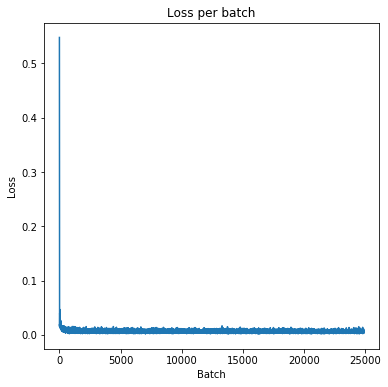

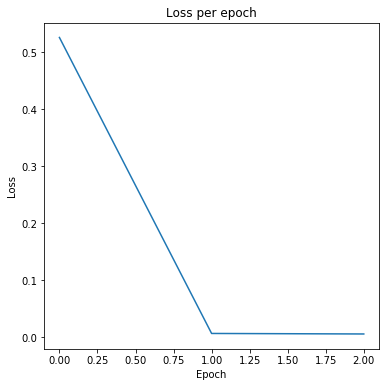

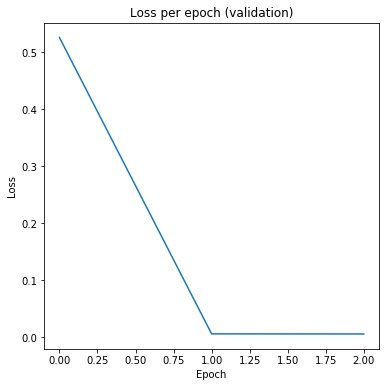

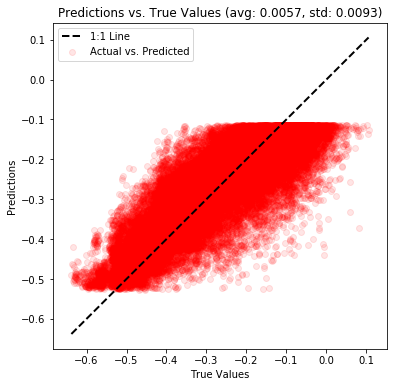

Mean loss: 0.005680472042165793, std loss: 0.009290117001077592


 --- SWEEP POINT 15/20: (2, 5, 1) ---
 --- time reamining: 00:11:43.52 

12 4
Epoch [0/2], Loss epoch: 1.0679, Loss validation: 1.0689
	 Validation string, 	 i: 1561; 	 prediction: -0.1802, 	 target: -0.1429, 	 loss: 0.0014
	 Validation string, 	 i: 1565; 	 prediction: -0.3956, 	 target: -0.4978, 	 loss: 0.0104
	 Validation string, 	 i: 872; 	 prediction: -0.1802, 	 target: 0.0034, 	 loss: 0.0337
Epoch [1/2], Loss epoch: 0.0212, Loss validation: 0.0098, Time remaining: ~0.0h 0.0m 21s
	 Validation string, 	 i: 2760; 	 prediction: -0.2333, 	 target: -0.1707, 	 loss: 0.0039
	 Validation string, 	 i: 4215; 	 prediction: -0.4395, 	 target: -0.4843, 	 loss: 0.0020
	 Validation string, 	 i: 1588; 	 prediction: -0.1693, 	 target: -0.0377, 	 loss: 0.0173
Epoch [2/2], Loss epoch: 0.0090, Loss validation: 0.0088, Time remaining: ~0.0h 0.0m 0s


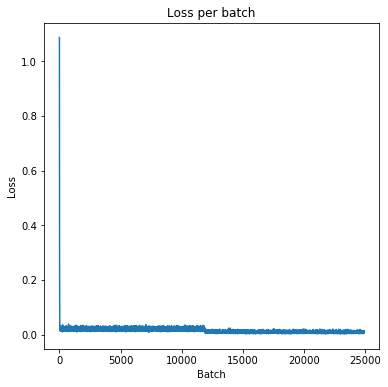

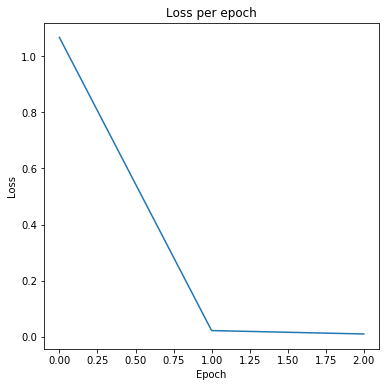

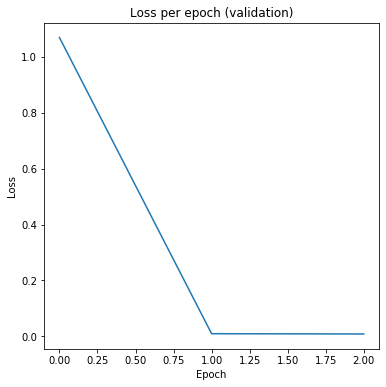

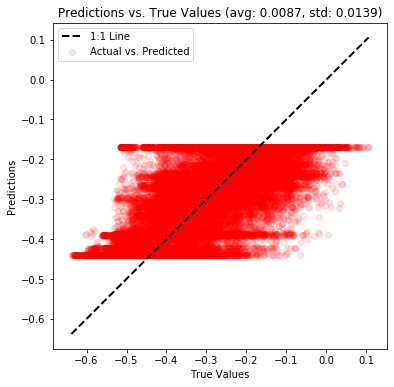

Mean loss: 0.008695556569427195, std loss: 0.013884595195359423


 --- SWEEP POINT 16/20: (2, 5, 5) ---
 --- time reamining: 00:09:27.45 

60 6
Epoch [0/2], Loss epoch: 0.3344, Loss validation: 0.3339
	 Validation string, 	 i: 580; 	 prediction: -0.2053, 	 target: -0.1940, 	 loss: 0.0001
	 Validation string, 	 i: 1693; 	 prediction: -0.1436, 	 target: -0.1402, 	 loss: 0.0000
	 Validation string, 	 i: 1743; 	 prediction: -0.1439, 	 target: -0.1220, 	 loss: 0.0005
Epoch [1/2], Loss epoch: 0.0101, Loss validation: 0.0074, Time remaining: ~0.0h 0.0m 21s
	 Validation string, 	 i: 506; 	 prediction: -0.4174, 	 target: -0.2698, 	 loss: 0.0218
	 Validation string, 	 i: 1473; 	 prediction: -0.1238, 	 target: -0.1233, 	 loss: 0.0000
	 Validation string, 	 i: 1517; 	 prediction: -0.2328, 	 target: -0.4031, 	 loss: 0.0290
Epoch [2/2], Loss epoch: 0.0069, Loss validation: 0.0065, Time remaining: ~0.0h 0.0m 0s


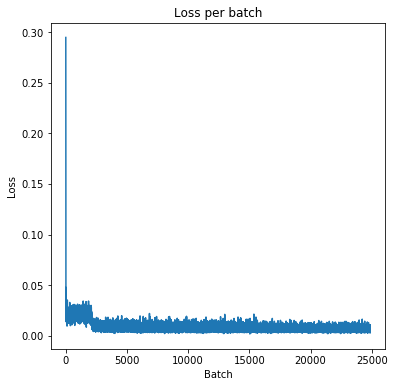

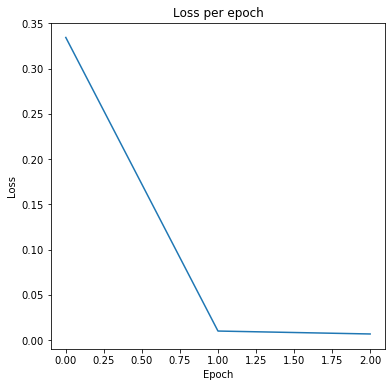

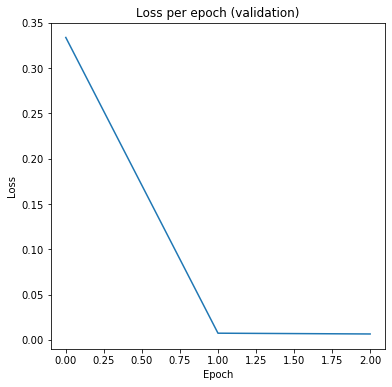

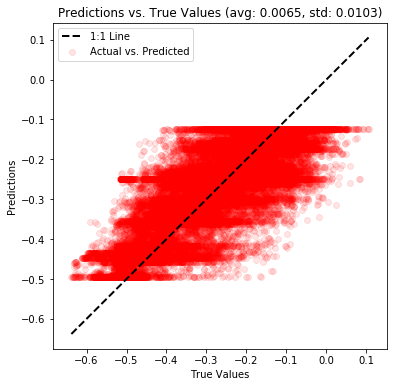

Mean loss: 0.00647307586795931, std loss: 0.010338050505433719


 --- SWEEP POINT 17/20: (2, 12, 1) ---
 --- time reamining: 00:07:20.67 

12 4
Epoch [0/2], Loss epoch: 0.1282, Loss validation: 0.1280
	 Validation string, 	 i: 1826; 	 prediction: -0.2627, 	 target: -0.1701, 	 loss: 0.0086
	 Validation string, 	 i: 2101; 	 prediction: -0.2627, 	 target: -0.5030, 	 loss: 0.0577
	 Validation string, 	 i: 3694; 	 prediction: -0.2627, 	 target: -0.2383, 	 loss: 0.0006
Epoch [1/2], Loss epoch: 0.0208, Loss validation: 0.0210, Time remaining: ~0.0h 0.0m 27s
	 Validation string, 	 i: 168; 	 prediction: -0.2750, 	 target: -0.2978, 	 loss: 0.0005
	 Validation string, 	 i: 1008; 	 prediction: -0.2750, 	 target: -0.0477, 	 loss: 0.0516
	 Validation string, 	 i: 2320; 	 prediction: -0.2750, 	 target: -0.2168, 	 loss: 0.0034
Epoch [2/2], Loss epoch: 0.0208, Loss validation: 0.0207, Time remaining: ~0.0h 0.0m 0s


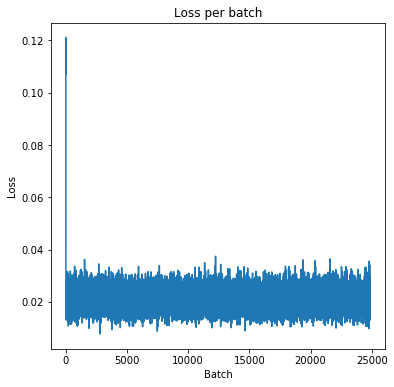

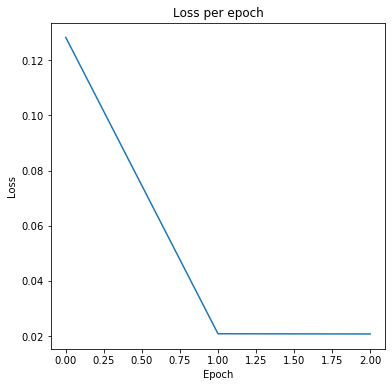

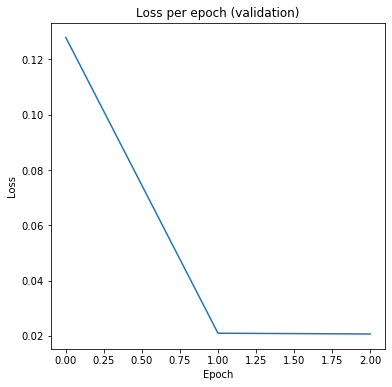

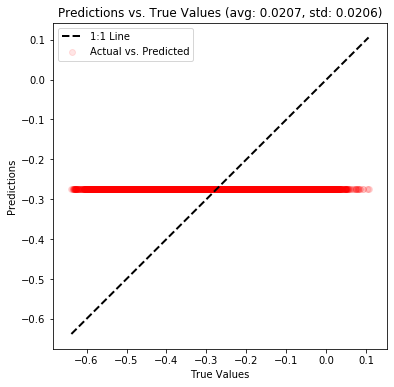

Mean loss: 0.02071813468996105, std loss: 0.020620078075603284


 --- SWEEP POINT 18/20: (2, 12, 5) ---
 --- time reamining: 00:05:24.79 

60 6
Epoch [0/2], Loss epoch: 0.0667, Loss validation: 0.0669
	 Validation string, 	 i: 2724; 	 prediction: -0.2895, 	 target: -0.2569, 	 loss: 0.0011
	 Validation string, 	 i: 3669; 	 prediction: -0.2895, 	 target: -0.1076, 	 loss: 0.0331
	 Validation string, 	 i: 2083; 	 prediction: -0.2895, 	 target: -0.5216, 	 loss: 0.0539
Epoch [1/2], Loss epoch: 0.0209, Loss validation: 0.0207, Time remaining: ~0.0h 0.0m 29s
	 Validation string, 	 i: 1836; 	 prediction: -0.2797, 	 target: -0.3562, 	 loss: 0.0058
	 Validation string, 	 i: 1517; 	 prediction: -0.2797, 	 target: -0.4031, 	 loss: 0.0152
	 Validation string, 	 i: 2972; 	 prediction: -0.2797, 	 target: -0.2409, 	 loss: 0.0015
Epoch [2/2], Loss epoch: 0.0208, Loss validation: 0.0207, Time remaining: ~0.0h 0.0m 0s


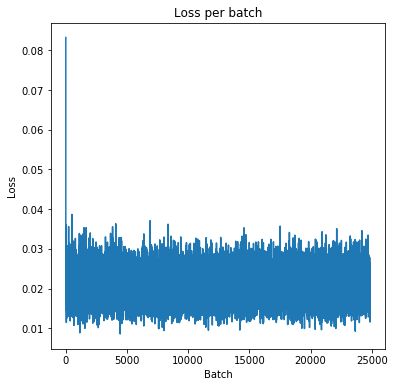

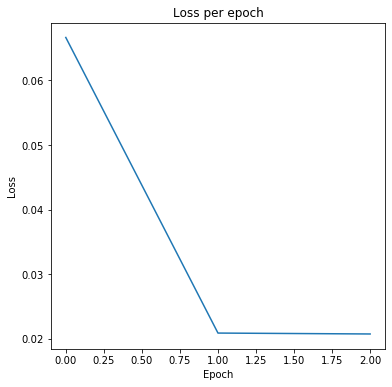

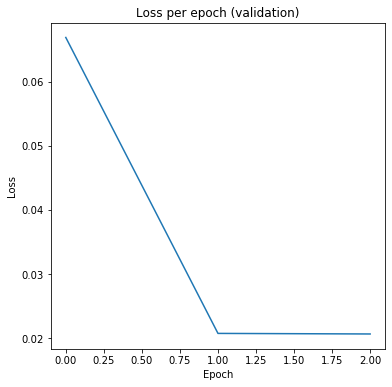

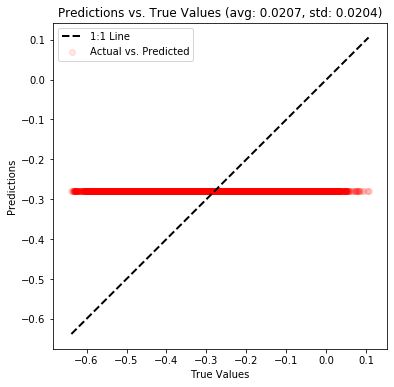

Mean loss: 0.020681206133234313, std loss: 0.02044937293289868


 --- SWEEP POINT 19/20: (2, 20, 1) ---
 --- time reamining: 00:03:33.49 

12 4
Epoch [0/2], Loss epoch: 0.4929, Loss validation: 0.4935
	 Validation string, 	 i: 747; 	 prediction: -0.2685, 	 target: -0.4820, 	 loss: 0.0456
	 Validation string, 	 i: 1788; 	 prediction: -0.2685, 	 target: -0.2303, 	 loss: 0.0015
	 Validation string, 	 i: 3805; 	 prediction: -0.2685, 	 target: -0.1651, 	 loss: 0.0107
Epoch [1/2], Loss epoch: 0.0211, Loss validation: 0.0208, Time remaining: ~0.0h 0.0m 31s
	 Validation string, 	 i: 4380; 	 prediction: -0.2953, 	 target: -0.3242, 	 loss: 0.0008
	 Validation string, 	 i: 2715; 	 prediction: -0.2953, 	 target: -0.1193, 	 loss: 0.0310
	 Validation string, 	 i: 1903; 	 prediction: -0.2953, 	 target: -0.1367, 	 loss: 0.0252
Epoch [2/2], Loss epoch: 0.0208, Loss validation: 0.0209, Time remaining: ~0.0h 0.0m 0s


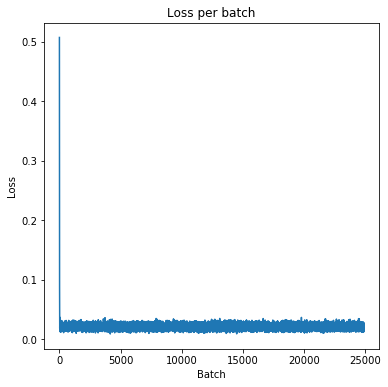

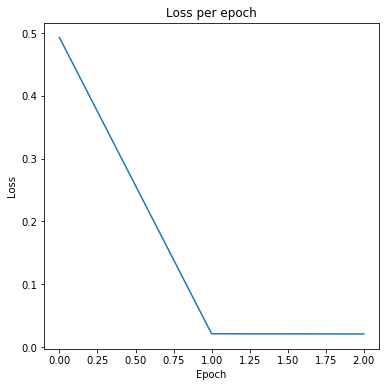

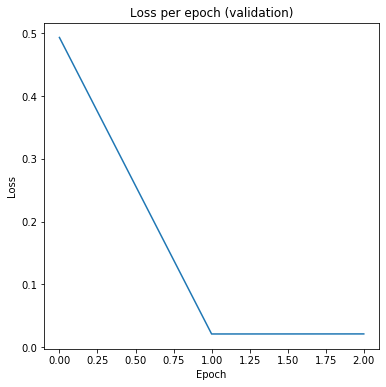

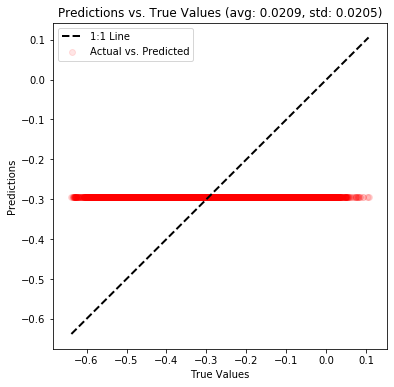

Mean loss: 0.0208778823618475, std loss: 0.020532933004861545


 --- SWEEP POINT 20/20: (2, 20, 5) ---
 --- time reamining: 00:01:45.96 

60 6
Epoch [0/2], Loss epoch: 0.0380, Loss validation: 0.0379
	 Validation string, 	 i: 4124; 	 prediction: -0.2993, 	 target: -0.2729, 	 loss: 0.0007
	 Validation string, 	 i: 4277; 	 prediction: -0.1941, 	 target: -0.1207, 	 loss: 0.0054
	 Validation string, 	 i: 4334; 	 prediction: -0.2048, 	 target: -0.2080, 	 loss: 0.0000
Epoch [1/2], Loss epoch: 0.0204, Loss validation: 0.0100, Time remaining: ~0.0h 0.0m 31s
	 Validation string, 	 i: 688; 	 prediction: -0.2968, 	 target: -0.1788, 	 loss: 0.0139
	 Validation string, 	 i: 3241; 	 prediction: -0.3686, 	 target: -0.4670, 	 loss: 0.0097
	 Validation string, 	 i: 186; 	 prediction: -0.2965, 	 target: -0.2549, 	 loss: 0.0017
Epoch [2/2], Loss epoch: 0.0080, Loss validation: 0.0073, Time remaining: ~0.0h 0.0m 0s


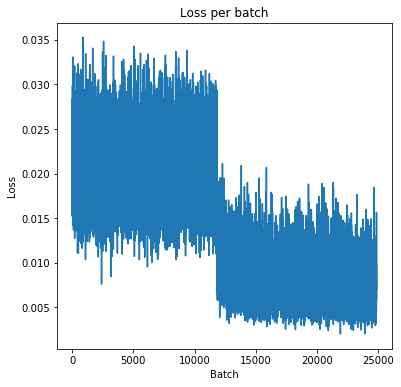

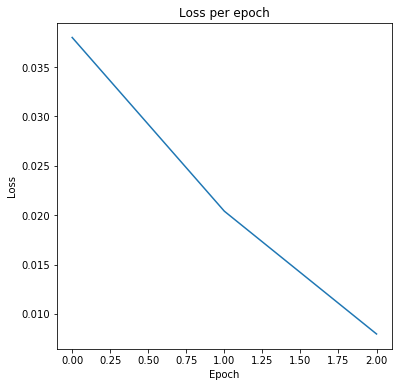

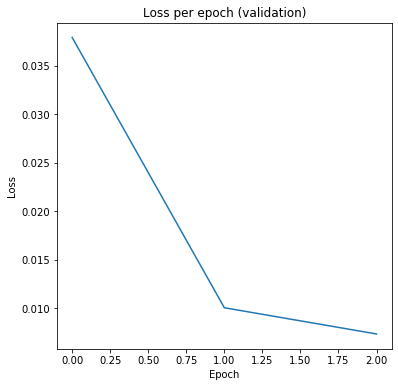

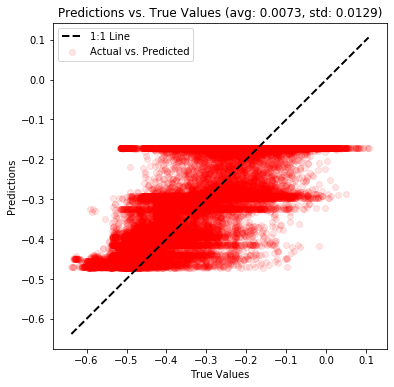

Mean loss: 0.007278822052530272, std loss: 0.01293578187759129


In [7]:
for sweep_point in sweep:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- MODEL -- #
                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=sweep_point['embedding_dim'])
            self.fc2 = m.Reshape()
            dim_block = 4 if sweep_point['embedding_dim'] == 1 else 6
            block = [m.nn.Linear(12*sweep_point['embedding_dim'], dim_block), m.nn.Sigmoid()]
            block += [m.nn.Linear(dim_block, dim_block), m.nn.Sigmoid()] * sweep_point['n_layers_block']
            self.fc3 = m.nn.Sequential(*block)
            self.fc4 = m.nn.Linear(dim_block, 1) 

        def forward(self, x):
            for i in range(1,5):
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    quantum_layer = None
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 12 amino acids all classical -> to compare with sweep_12h_e_Am_Xqm',    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 2,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    